<a href="https://colab.research.google.com/github/sherlock-beep/tf_learn/blob/main/tf_learn9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用tensorflow实现迁移学习实现对猫和狗的图像分类模型

In [3]:
#导入相关库
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [4]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

# ! ls /root/.keras/datasets/cats_and_dogs_filtered

train_dir = os.path.join(PATH,'train')
validation_dir = os.path.join(PATH,'validation')
BATCH_SIZE=32
IMG_SIZE = (160,160)
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                    shuffle=True,
                                                                    batch_size = BATCH_SIZE,
                                                                    image_size=IMG_SIZE)


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                   batch_size = BATCH_SIZE,
                                                  image_size=IMG_SIZE)  

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


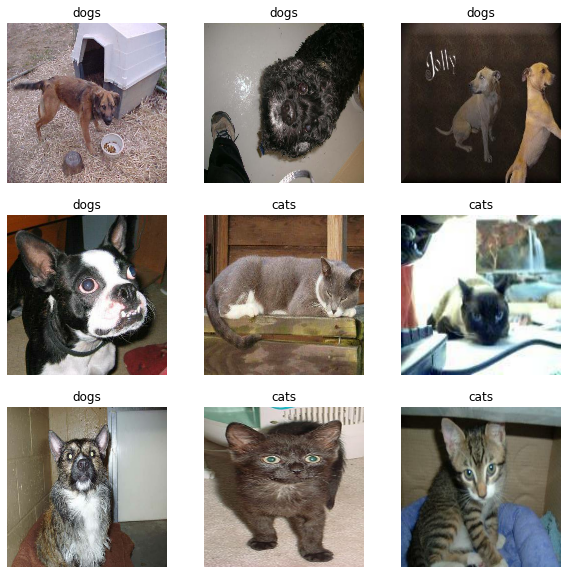

In [5]:
class_names = train_dataset.class_names
#查看训练集中的前9个图像
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
#获取验证集的batch数量
val_batches = tf.data.experimental.cardinality(validation_dataset)
#取验证集的6个batch为test_dataset
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
#配置数据集提高性能，使用预缓存
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size= AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
#进行数据增强
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

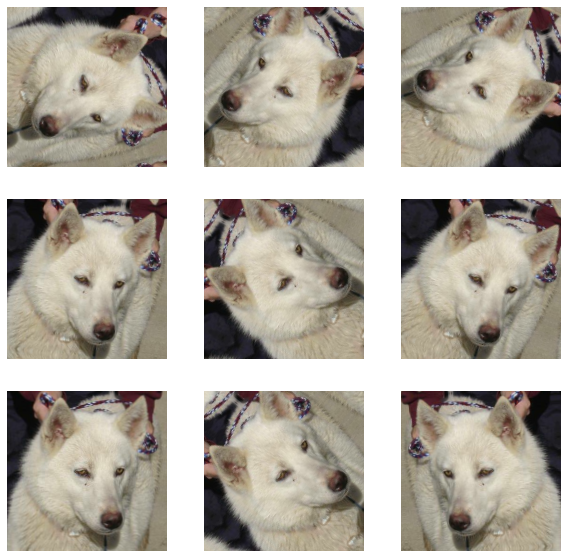

In [9]:
#查看数据增强效果
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')



In [10]:
#使用google的MobileNet V2 模型作为预训练模型
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9420800/9406464 [==============================] - 0s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:
#图片像素缩放层
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [13]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [14]:
#查看v2的架构
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
#logits正数预测 1 类，负数预测 0 类。
print(prediction_batch.shape)

(32, 1)


In [17]:
#建立完整模型
inputs = tf.keras.Input(shape=(160,160,3)) #输入层
x = data_augmentation(inputs) #数据增强
x = preprocess_input(x) #图片像素缩放层
x = base_model(x,training=False) #预训练模型
x = global_average_layer(x) #池化层
x = tf.keras.layers.Dropout(0.2)(x) #正则化层，降低模型过拟合
outputs = prediction_layer(x) #输出层
model = tf.keras.Model(inputs,outputs)

#编译模型
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [18]:
#未训练模型的评估
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

26/26 [==============================] - 4s 44ms/step - loss: 0.8888 - accuracy: 0.4035
initial loss: 0.89
initial accuracy: 0.40


In [19]:
#训练模型
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 8s 64ms/step - loss: 0.8491 - accuracy: 0.4760 - val_loss: 0.6108 - val_accuracy: 0.5879
Epoch 2/10
63/63 [==============================] - 4s 60ms/step - loss: 0.6282 - accuracy: 0.6220 - val_loss: 0.4321 - val_accuracy: 0.7525
Epoch 3/10
63/63 [==============================] - 4s 66ms/step - loss: 0.4972 - accuracy: 0.7350 - val_loss: 0.3299 - val_accuracy: 0.8589
Epoch 4/10
63/63 [==============================] - 5s 69ms/step - loss: 0.4085 - accuracy: 0.7905 - val_loss: 0.2673 - val_accuracy: 0.8861
Epoch 5/10
63/63 [==============================] - 4s 60ms/step - loss: 0.3468 - accuracy: 0.8405 - val_loss: 0.2196 - val_accuracy: 0.9208
Epoch 6/10
63/63 [==============================] - 4s 60ms/step - loss: 0.3140 - accuracy: 0.8555 - val_loss: 0.1957 - val_accuracy: 0.9233
Epoch 7/10
63/63 [==============================] - 4s 60ms/step - loss: 0.2815 - accuracy: 0.8720 - val_loss: 0.1725 - val_accuracy: 0.9356
Epoch 8/10
63

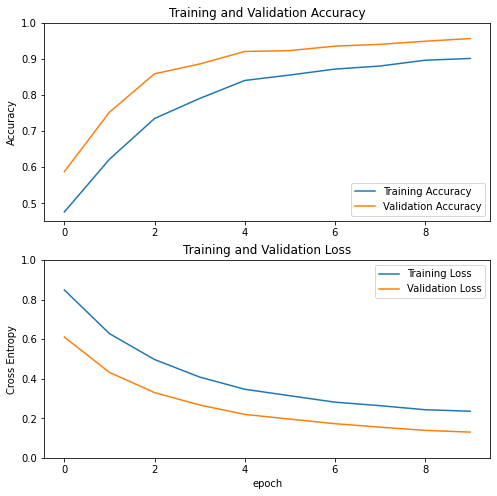

In [20]:
#画出模型的学习曲线
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
#对预训练模型进行微调，使新模型更加适应新训练集
print("Number of layers in the base model: ", len(base_model.layers))
base_model.trainable = True #解冻预训练模型
fine_tune_at = 100 #冻结预训练模型的层数
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False




Number of layers in the base model:  154


In [25]:
#重新编译模型
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 160, 160, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 160, 160, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [26]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 13s 82ms/step - loss: 0.1554 - accuracy: 0.9410 - val_loss: 0.0538 - val_accuracy: 0.9777
Epoch 11/20
63/63 [==============================] - 5s 69ms/step - loss: 0.1252 - accuracy: 0.9475 - val_loss: 0.0576 - val_accuracy: 0.9827
Epoch 12/20
63/63 [==============================] - 5s 69ms/step - loss: 0.1136 - accuracy: 0.9515 - val_loss: 0.0433 - val_accuracy: 0.9851
Epoch 13/20
63/63 [==============================] - 5s 70ms/step - loss: 0.0946 - accuracy: 0.9590 - val_loss: 0.0521 - val_accuracy: 0.9715
Epoch 14/20
63/63 [==============================] - 5s 68ms/step - loss: 0.0948 - accuracy: 0.9620 - val_loss: 0.0299 - val_accuracy: 0.9864
Epoch 15/20
63/63 [==============================] - 5s 69ms/step - loss: 0.0864 - accuracy: 0.9655 - val_loss: 0.0370 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 5s 75ms/step - loss: 0.0796 - accuracy: 0.9660 - val_loss: 0.0392 - val_accuracy: 0.9802
Epoch

In [28]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

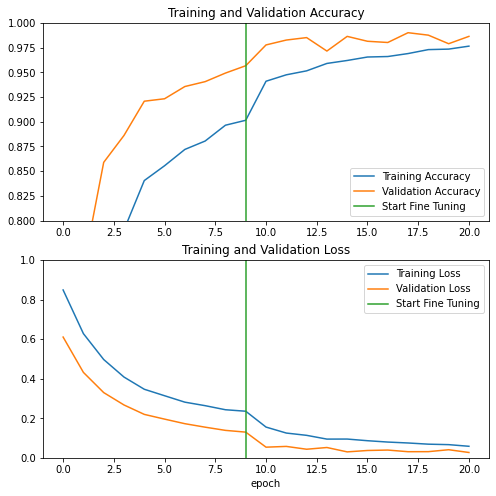

In [29]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:
#评估微调后的模型
loss,accuracy = model.evaluate(test_dataset)
print('Test accuracy:',accuracy)

6/6 [==============================] - 1s 46ms/step - loss: 0.0407 - accuracy: 0.9896
Test accuracy: 0.9895833134651184


Predictions:
 [1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0]
Labels:
 [1 1 1 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 0]


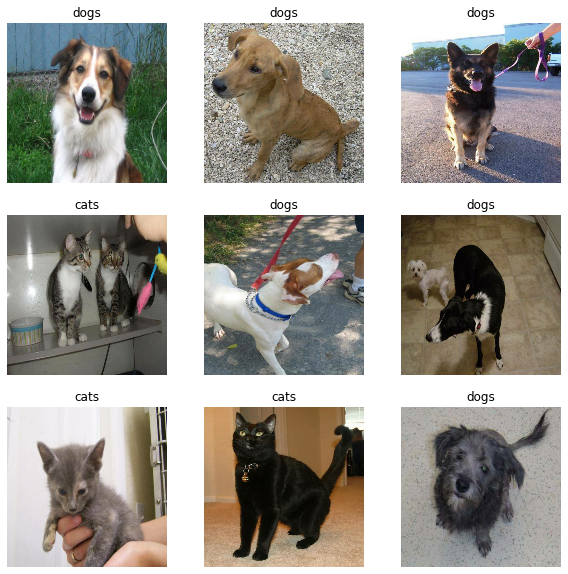

In [36]:

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")